# Plotting Source Sink Cross Validation Experiment

Acknowledgements: See https://github.com/sipv/MultipanelFigures/blob/main/MultipanelFigures.ipynb for a great explanation on laying out figures in matplotlib

In [4]:
%load_ext lab_black

In [1]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import re

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from sklearn.metrics import auc

import pingouin as pg
from mlxtend.evaluate import mcnemar_table, mcnemar
import dabest

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Options

In [2]:
# Set font sizes
SMALL_SIZE = 8 * 2
MEDIUM_SIZE = 10 * 2
BIGGER_SIZE = 12 * 2

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

In [3]:
def load_participant_df(root, subject):
    """Load participants.tsv file as a dataframe for a specific subject.
    
    Note: subject ID needs to be in format ``sub-<subject>``.
    """
    df = pd.read_csv(os.path.join(root, 'participants.tsv', sep='\t'))
    
    if not subject.startswith('sub-'):
        subject = f'sub-{subject}'
    subj_row = df[df['participant_id'] == subject]
    return subj_row

# Load Data

In [4]:
jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

# not ready yet
upmcroot = Path("D:/OneDriveParent/Johns Hopkins/UPMC_Scalp - Documents/scalp_study/root")

In [5]:
root =  Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"

reference = "monopolar"
deriv_chain = Path("sourcesink") / reference 
deriv_path = deriv_root / deriv_chain

combined_deriv_root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Scalp_EEG_combined/derivatives")

In [6]:
figure_dir = deriv_root / "figures"

## Load Experimental Data from JSON - output of sklearn's "cross_validate" function

In [7]:
# here name the experiment something that is uniquely identifiable
# THIS STR WILL BE USED TO PREFIX/SUFFIX ALL FIGURES DOWNSTREAM
exp_name = "ssdist"

In [8]:
n_splits = 10

clf_name = "rf"
n_features = 32
n_estimators = (2000,)
max_features = n_features

In [9]:
# specify the filenmae
fname = (
    deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_{exp_name}_meandiff.json"
)
print(fname)

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\cv10_rf_mtry32_exp_ssdist_meandiff.json


In [10]:
with open(fname.with_suffix(".json"), "r") as fp:
    scores = json.load(fp)

In [11]:
max_features = 10

## Load Metadata DataFrame

In [11]:
meta_df = pd.DataFrame()
for root in [jhroot]:
    df = pd.read_csv(os.path.join(root, "participants.tsv"), sep="\t")
    meta_df = pd.concat((meta_df, df), axis=0)

# meta_df = pd.concat(df_list, axis=0)

display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition
0,sub-jhh001,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg
1,sub-jhh002,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg
2,sub-jhh003,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg
3,sub-jhh004,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg
4,sub-jhh005,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg


# Make Plots of the Source Sink Data

In [12]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

## Print out Summary Statistics

In [13]:
print(np.mean(aucs), np.std(aucs))

0.4833333333333333 0.07393273552842508


In [14]:
print(np.mean(aucs), np.std(aucs))

0.4833333333333333 0.07393273552842508


In [15]:
metric = "test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.4488888888888889 +/- 0.0772122295692964


In [16]:
metric = "test_average_precision"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_average_precision 0.6989960192313825 +/- 0.060868573775120886


In [17]:
metric = "test_recall"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall 0.7277777777777777 +/- 0.13933262448871614


In [18]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_specificity 0.17 +/- 0.06403124237432849


In [19]:
metric = "test_f1"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1 0.6595199380565234 +/- 0.0893747788911356


In [20]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)
score_df.drop(score_df.tail(1).index,inplace=True) # drop last n rows

display(score_df.tail())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1,test_specificity,test_y,test_y_encodings
4,0.522125,0.168038,0.458333,0.500000,0.411111,0.718039,0.590909,-0.275939,0.722222,0.650000,0.1,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","[non-epilepsy-normal-eeg, epilepsy-abnormal-ee..."
5,0.528823,0.172919,0.411111,0.392857,0.350000,0.666711,0.529412,-0.329622,0.500000,0.514286,0.2,"[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, ...","[non-epilepsy-normal-eeg, epilepsy-abnormal-ee..."
6,0.527172,0.164037,0.588889,0.642857,0.544444,0.768412,0.666667,-0.227890,0.888889,0.761905,0.2,"[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, ...","[non-epilepsy-normal-eeg, epilepsy-abnormal-ee..."
7,0.527118,0.167037,0.511111,0.607143,0.516667,0.667254,0.652174,-0.241626,0.833333,0.731707,0.2,"[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...","[non-epilepsy-normal-eeg, non-epilepsy-normal-..."
8,0.527125,0.163037,0.488889,0.571429,0.466667,0.653002,0.625000,-0.267440,0.833333,0.714286,0.1,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[non-epilepsy-normal-eeg, epilepsy-abnormal-ee..."


In [21]:
score_df.describe().to_csv(figure_dir / f"{exp_name}_{exp_name}_metrics_meansstd.csv")

## Making ROC Curve With Confidence Interval

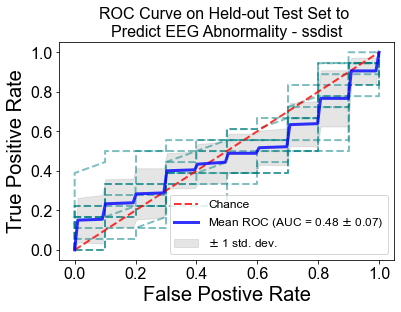

In [22]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set to \nPredict EEG Abnormality - {exp_name}",
    xlabel="False Postive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
fig.savefig(
    figure_dir / f"roc_curve_{exp_name}_withoutabnormaleeg.pdf", bbox_inches="tight"
)

In [23]:
subjects_ = scores['test_subjects']
subjects = [item for sublist in subjects_ for item in sublist]
y_pred_proba_ = scores['test_y_pred_proba']
y_pred_proba = [item for sublist in y_pred_proba_ for item in sublist]
y_pred_proba = np.array(y_pred_proba)

In [24]:
groups = []
centers = []
for subject in subjects:
    sub = int(re.search(r'\d+', subject).group())
    center = ''.join([i for i in subject if not i.isdigit()])
    if sub < 100:
        groups.append(0)
    elif sub > 200:
        groups.append(2)
    else:
        groups.append(1)
    centers.append(center)

In [110]:
[print(g,c) for g,c in zip(groups, centers)]

0 jhh
0 jeff
1 jhh
2 jhh
2 jeff
1 jhh
1 jhh
2 jeff
1 jhh
2 jhh
2 jeff
0 jhh
2 jeff
0 jhh
2 jeff
0 jhh
2 jeff
1 jhh
0 jhh
1 jhh
2 jhh
1 jhh
1 jhh
1 jhh
2 jeff
2 jhh
0 jhh
0 jeff
1 jhh
0 jhh
2 jeff
2 jhh
2 jhh
0 jhh
2 jhh
0 jhh
2 jhh
0 jhh
1 jhh
1 jeff
2 jhh
1 jhh
1 jeff
1 jhh
2 jeff
0 jhh
1 jhh
2 jeff
2 jeff
0 jhh
1 jeff
2 jeff
0 jeff
2 jhh
0 jhh
1 jhh
2 jhh
2 jhh
1 jeff
2 jeff
2 jhh
0 jhh
1 jeff
0 jhh
0 jhh
1 jhh
1 jhh
1 jhh
2 jhh
0 jeff
2 jhh
1 jhh
2 jeff
1 jhh
2 jhh
0 jhh
2 jhh
1 jhh
0 jhh
0 jeff
2 jeff
2 jeff
0 jhh
2 jhh
2 jhh
1 jhh
2 jeff
0 jhh
2 jeff
1 jhh
2 jhh
0 jhh
1 jhh
2 jeff
0 jhh
0 jhh
1 jhh
2 jeff
2 jeff
1 jhh
2 jeff
0 jhh
2 jeff
0 jhh
1 jhh
0 jhh
2 jhh
0 jhh
2 jhh
2 jhh
1 jeff
1 jhh
0 jhh
1 jhh
0 jhh
2 jhh
2 jeff
1 jeff
0 jhh
2 jeff
1 jeff
2 jeff
0 jhh
1 jeff
1 jhh
2 jeff
2 jeff
1 jhh
0 jhh
1 jhh
1 jeff
2 jeff
0 jhh
0 jhh
1 jeff
2 jeff
2 jeff
0 jhh
2 jeff
2 jeff
1 jhh
2 jeff
2 jeff
2 jhh
2 jhh
2 jeff
2 jeff
2 jeff
2 jeff
2 jhh
2 jeff
2 jhh
2 jhh
2 jhh
2 jhh
2 jeff


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [25]:
predict_df = pd.DataFrame()
predict_df['subject'] = subjects
predict_df['group'] = groups
predict_df['pred'] = y_pred_proba
predict_df['center'] = centers

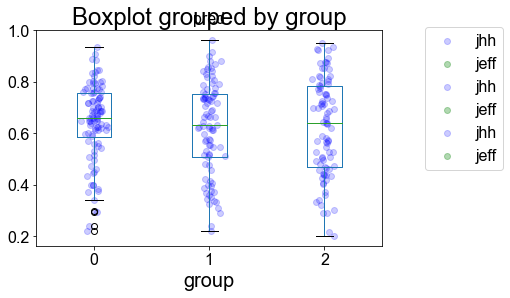

In [26]:
bp = predict_df.boxplot(column='pred', by='group', grid=False)
for group in [0,1,2]:
    group_inds_jhh = [i for i, val in enumerate(groups) if val == group and centers[i]=='jhh']
    ypred_group_jhh = y_pred_proba[group_inds_jhh]
    x_jhh = np.random.normal(group+1, 0.04, size=len(ypred_group_jhh))
    plt.scatter(x_jhh, ypred_group_jhh, alpha=0.2, c="b", label='jhh')
    group_inds_jeff = [i for i, val in enumerate(groups) if val == group and centers[i]=='jeff']
    ypred_group_jeff = y_pred_proba[group_inds_jeff]
    x_jeff = np.random.normal(group+1, 0.04, size=len(ypred_group_jeff))
    plt.scatter(x_jeff, ypred_group_jeff, alpha=0.3, c="g", label='jeff')
plt.legend(bbox_to_anchor=(1.1, 1.05))

## Plotting Predicted Probability of Success Scores

In [19]:
source_root = jhroot / "sourcedata"
meta_fpath = source_root / "JHU_scalp_clinical_datasheet_raw_local.xlsx"
meta_df = pd.read_excel(meta_fpath)
display(meta_df.head(2))

,patient_id,hospital_id,number_datasets,CLINICAL_CENTER,modality,montage,sfreq,GROUP,ETHNICITY,"Race (0=caucasian, 1=african american, 2=hispanic, 3=asian)",...,HAND,GENDER,bad_contacts,EPILEPSY_TYPE,imaging_outcome_notes,Date of Recording,Notes,include,Reason,best_window
0,101,1,1,jhh,scalp,standard 10-20,200,1,NaN,NaN,...,NaN,NaN,"Fz, Cz, E, X1-7, SpO2, EtCO2, DC03, DC04, DC05...",focal,NaN,NaN,"Lots of eye artifact. Pz looks more normal, bu...",Y,"Good after 100 s, remove Pz",100-400
1,201,2,1,jhh,scalp,standard 10-20,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,SHW',Y,Riddled with artifact,600-900


In [20]:
# TODO: modify to fit the participants framework
y_probas = []
subj_list = []
outcomes = []
centers = []
folds = []

for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]
    cv_subjects = scores[f"{which_set}_subjects"][idx]
    for subject in cv_subjects:
        outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
        outcomes.append(outcome)

        center = meta_df[meta_df["patient_id"] == subject]["clinical_center"].values[0]
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

KeyError: 'outcome'

In [29]:
proba_df = pd.DataFrame(
    (y_probas, subj_list, outcomes, engels, ilaes, centers, folds)
).T
proba_df.columns = ["y_proba", "subject", "outcome", "engel", "ilae", "center", "fold"]

proba_df["center"] = proba_df["center"].map(
    {
        "jhu": "JHH",
        "miami": "Miami",
        "cc": "CClinic",
        "upmc": "UPMC",
        "kumc": "KUMC",
        "nih": "NIH",
    }
)

display(proba_df.head())

,y_proba,subject,outcome,engel,ilae,center,fold
0,0.609425,PY19N023,S,1,1.0,JHH,0
1,0.335533,la16,F,4,5.0,CClinic,0
2,0.292,rns015,F,2,NaN,Miami,0
3,0.653967,upmc3,F,2,3.0,UPMC,0
4,0.551758,la21,S,1,1.0,CClinic,0


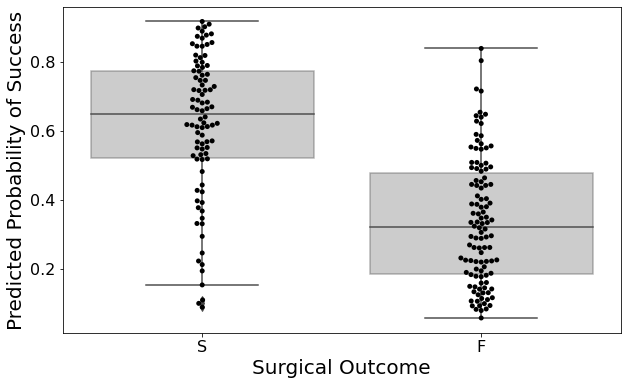

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="outcome",
    y="y_proba",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(x="outcome", y="y_proba", color="black", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="Surgical Outcome",
)
fig.savefig(figure_dir / f"{exp_name}_y_pred_proba_surgical_outcomes.pdf", bbox_inches="tight")

## Boundary Split Figure

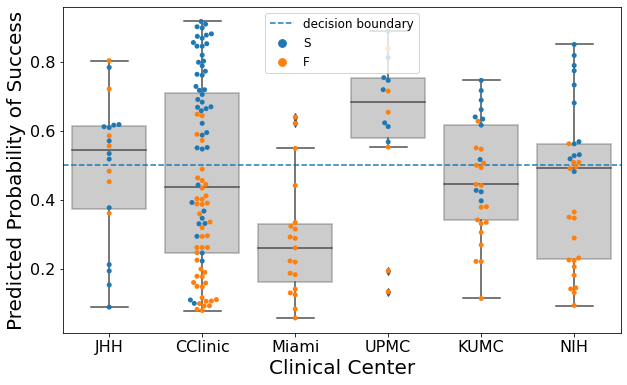

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axhline([0.5], ls="--", label="decision boundary")
sns.boxplot(
    x="center",
    y="y_proba",
    data=proba_df,
    color="gray",
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(x="center", y="y_proba", hue="outcome", data=proba_df, ax=ax)
ax.set(
    ylabel="Predicted Probability of Success",
    xlabel="Clinical Center",
)
ax.legend(fontsize=12)
fig.savefig(figure_dir / f"{exp_name}_boundary_split_center.pdf", bbox_inches="tight")

## Plotting Calibration Curve

In [36]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

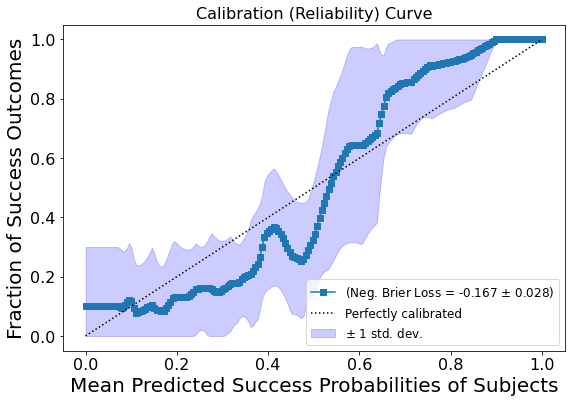

In [37]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots(figsize=(9, 6))
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"(Neg. Brier Loss = {np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)})",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Success Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Success Probabilities of Subjects",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right", fontsize=12)

fig.savefig(figure_dir / f"{exp_name}_calibration_curve.pdf", bbox_inches="tight")

# McNemars Test To Compare Two Different Classification Scenarios

In [55]:
from numpy.testing import assert_array_equal

In [56]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

In [57]:
y_target = []
y_modelhfo = []
y_modelss = []

y_subjs = []
for idx in range(n_splits):
    y = ss_scores["test_subjects"][idx]
    hfo_y = hfo_scores["test_subjects"][idx]

    assert_array_equal(y, hfo_y)
    y_subjs.extend(y)

    y_predhfo = hfo_scores["test_y_pred_proba"][idx]
    y_predss = ss_scores["test_y_pred_proba"][idx]
    y_modelhfo.extend(y_predhfo)
    y_modelss.extend(y_predss)

In [58]:
for subject in y_subjs:
    outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
    y_target.append(outcome)

y_target = enc.fit_transform(np.array(y_target)[:, np.newaxis]).squeeze()
y_modelss = np.array(y_modelss).round()
y_modelhfo = np.array(y_modelhfo).round()

In [59]:
tb = mcnemar_table(y_target=y_target, y_model1=y_modelss, y_model2=y_modelhfo)
print(tb)

[[98 60]
 [33  9]]


In [60]:
chi2, p = mcnemar(ary=tb, corrected=True)
print("chi-squared:", chi2)
print("p-value:", p)

chi-squared: 7.268817204301075
p-value: 0.0070161992342396284


# Plots Comparing HFO and Source Sink

In [59]:
which_set = "test"

aucs = []
precisions = []
recalls = []
specificities = []
accuracies = []
clfs = []

for clf in ["HFO", "Source-Sink"]:
    if clf == "HFO":
        scores = hfo_scores
    elif clf == "Source-Sink":
        scores = ss_scores

    for idx in range(n_splits):
        auc_ = scores[f"{which_set}_roc_auc"][idx]
        precision_ = scores[f"{which_set}_average_precision"][idx]
        acc = scores[f"{which_set}_balanced_accuracy"][idx]
        sens = scores[f"{which_set}_recall"][idx]
        spec = scores[f"{which_set}_specificity"][idx]

        aucs.append(auc_)
        precisions.append(precision_)
        accuracies.append(acc)
        recalls.append(sens)
        specificities.append(spec)
        clfs.append(clf)

comp_df = pd.DataFrame((aucs, precisions, accuracies, recalls, specificities, clfs)).T
comp_df.columns = [
    "AUC",
    "Average Precision",
    "Accuracy",
    "Sensitivity",
    "Specificity",
    "Feature",
]

In [60]:
display(comp_df.head())

,AUC,Average Precision,Accuracy,Sensitivity,Specificity,Feature
0,0.787879,0.821022,0.787879,0.666667,0.909091,HFO
1,0.656566,0.665096,0.575758,0.333333,0.818182,HFO
2,0.727273,0.636522,0.676768,0.444444,0.909091,HFO
3,0.555556,0.615104,0.414141,0.555556,0.272727,HFO
4,0.707071,0.748319,0.69697,0.666667,0.727273,HFO


In [61]:
df = pd.melt(
    comp_df,
    id_vars=["Feature"],
    value_name="Value",
    var_name="Metric",
)

display(df.head())

,Feature,Metric,Value
0,HFO,AUC,0.787879
1,HFO,AUC,0.656566
2,HFO,AUC,0.727273
3,HFO,AUC,0.555556
4,HFO,AUC,0.707071


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


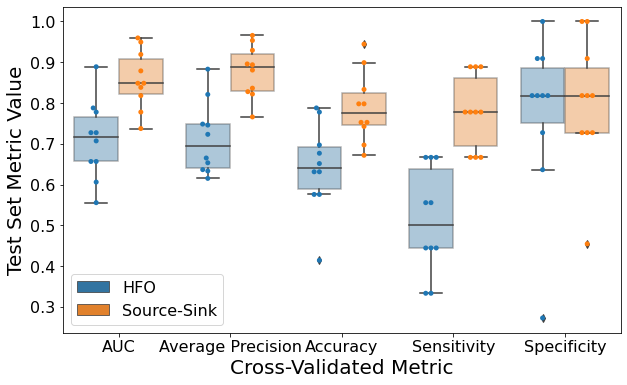

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="Metric", y="Value", hue="Feature", data=df, ax=ax, boxprops=dict(alpha=0.4)
)
sns.swarmplot(x="Metric", y="Value", hue="Feature", data=df, ax=ax, split=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.set(
    xlabel="Cross-Validated Metric",
    ylabel="Test Set Metric Value",
)
fig.savefig(figure_dir / "compare_metrics.pdf", bbox_inches="tight")

# Look at Feature Importances

In [88]:
scores = ss_scores

In [89]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_roc_auc', 'train_roc_auc', 'test_accuracy', 'train_accuracy', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_average_precision', 'train_average_precision', 'test_precision', 'train_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_recall', 'train_recall', 'test_f1', 'train_f1', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity'])


In [93]:
importances = scores["test_importances"]
print(len(importances))

10


In [ ]:
mean_imp = scores["test_neg_brier_score"]
std_imp = scores["test_"]